In [5]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

This notebook accompanies the [week15] practice. Refer to the classwork for more details.


Your last and ultimate task is to implement and train __Convolutional Conditional VAE__. Simple VAE is available in week 15. For details about conditional VAE one can refer to [week 15 lecture](https://github.com/girafe-ai/ml-mipt/tree/advanced/week15_generative) or [this habr post (ru)](https://habr.com/ru/post/331664/)

If it seems too easy, you can use [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset instead of MNIST.

The code in general duplicates the one from the in-class practice. 

Do not forget to __use GPU acceleration during training__.

In [6]:
%matplotlib inline

In [7]:
from torchsummary import summary
import seaborn as sns
sns.set()

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

__Currently you are using device:__

In [9]:
print(device)

cuda


In [10]:
# It's dangerous to walk alone. Take these ;)

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view(self.initial_shape)#x.view([-1]+list(self.initial_shape))

__Data loading stuff is done for you ;)__

In [11]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
])

In [12]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [13]:
data_root = './'

In [14]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [15]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

In [21]:
def transform_to_onehot(labels, num_classes, device):
    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)
    return labels_onehot

__The code below is simple VAE. Your task is to make in convolutional (both encoder and decoder) and add class label information.__

In [22]:
class ConvolutionalCVAE(nn.Module):
    def __init__(self, num_classes, latent_dim=10):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.num_classes = num_classes

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu,
            scale=self._initial_sigma
        )
        # the code is taken from here:
        # https://www.tensorflow.org/tutorials/generative/cvae
        intermediate_dim = 6272
        self.encoder = nn.Sequential(*[
            # convolution
            nn.Conv2d(in_channels=1, out_channels=16, 
                      kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(in_channels=16, out_channels=8, 
                      kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(in_channels=8, out_channels=8, 
                      kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Flatten(),
        ])

        self.linear = nn.Linear(intermediate_dim + self.num_classes, 128)
        self.mu_repr = nn.Linear(128, latent_dim) 
        self.log_sigma_repr = nn.Linear(128, latent_dim)
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim+self.num_classes, 4*4*8),
            # https://arxiv.org/pdf/2012.00985.pdf
            # https://www.tensorflow.org/tutorials/generative/cvae
            RestoreShape((-1, 8, 4, 4)),
            # convolution
            nn.Conv2d(in_channels=8, out_channels=8, 
                      kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=8, out_channels=8, 
                      kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            # convolution
            nn.Conv2d(in_channels=8, out_channels=16, 
                      kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            # convolution
            nn.Conv2d(in_channels=16, out_channels=1, 
                      kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        ])
    
    def _encode(self, features, targets):
        # one-hot tensor 10 channels
        # 3rgb + 10 additional labels
        onehot_targets = transform_to_onehot(targets, self.num_classes, device)
        x = features

        x = self.encoder(x)
        x = torch.cat((x, onehot_targets), dim = 1)
        latent_repr = self.linear(x)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr
    
    def  _decode(self, encoded, targets):
        onehot_targets = transform_to_onehot(targets, self.num_classes, device)
        x = torch.cat((encoded, onehot_targets), dim=1)
        decoded = self.decoder(x)
        return decoded
    
    # sample * variance + average
    # get the object in latent space
    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = torch.exp(log_sigma_values) * sample + mu_values
        return latent_sample

    def forward(self, x, y, raw_sample=None):
        mu_values, log_sigma_values, latent_repr = self._encode(x, y)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)
        
        reconstructed_repr =  self._decode(latent_sample, y)
        
        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [23]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    return fig

In [24]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]
latent_dim = 64

# use new defined class
model = ConvolutionalCVAE(10, latent_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(example_batch[0][:15].to(device),
                                                                       example_batch[1][:15].to(device))

In [36]:
# computation of kl loss is also taken from here:
# https://www.tensorflow.org/tutorials/generative/cvae

In [25]:
kl_loss = 0.5 * torch.mean(torch.sum(mu_values.pow(2) + torch.exp(log_sigma_values) - log_sigma_values - 1.0,
    dim = -1
))
kl_loss

tensor(0.1649, device='cuda:0', grad_fn=<MulBackward0>)

In [26]:
test_batch = next(iter(test_loader))

In [27]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        out = model(test_batch[0].to(device), test_batch[1].to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [28]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [33]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
num_classes = 10
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim + num_classes))
            z_sample[:, :2] = np.array([[xi, yi]])
            
            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)
            x_decoded = model.decoder(z_torch).detach().cpu().numpy()
            digit = x_decoded[0]
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
        # plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

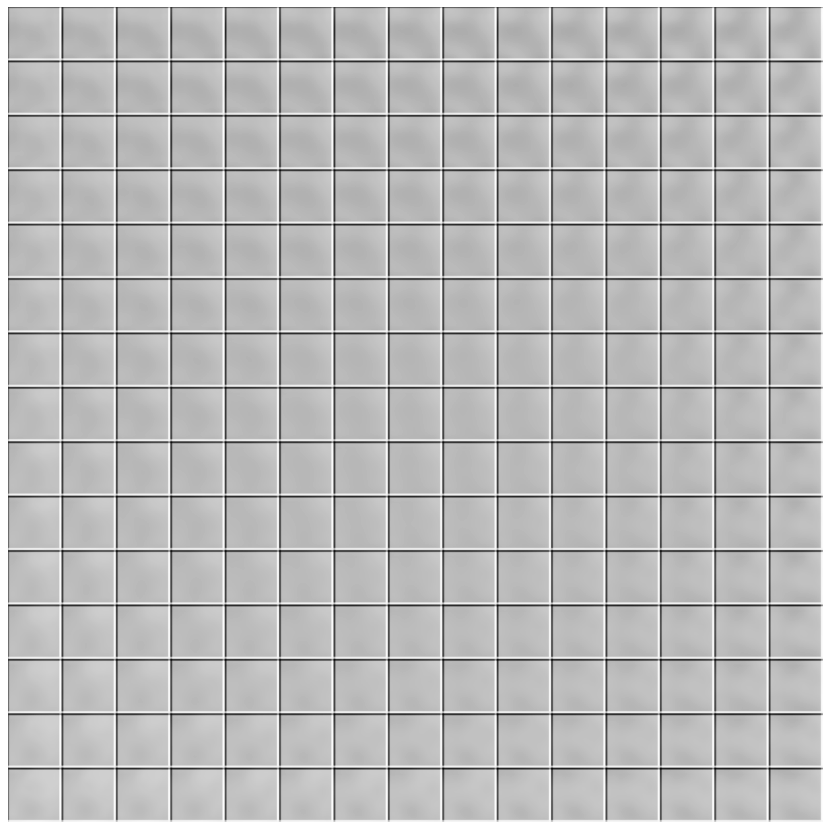

In [34]:
model.eval()
_img = draw_manifold(model, True)

In [35]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [38]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            batch_label = batch_label.to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x, batch_label)

            # https://www.tensorflow.org/tutorials/generative/cvae
            kl_loss = 0.5 * torch.mean(torch.sum(
                mu_values.pow(2) + torch.exp(log_sigma_values) - log_sigma_values - 1.,
                dim = -1
            ))
            
            bce_loss = 28*28*loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss.item()/(len(train_loader.dataset))
            bce_acc += bce_loss.item()/(len(train_loader.dataset))
            kl_acc += kl_loss.item()/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [40]:
epochs, figs, latent_distrs = train(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch num: 0
Training loss=0.0004, KL divergence=0.0681, BCE Loss=0.5140


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Epoch num: 5
Training loss=0.0003, KL divergence=0.0631, BCE Loss=0.4701


Epoch num: 10
Training loss=0.0003, KL divergence=0.0596, BCE Loss=0.4442


Epoch num: 15
Training loss=0.0003, KL divergence=0.0592, BCE Loss=0.4249


In [43]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

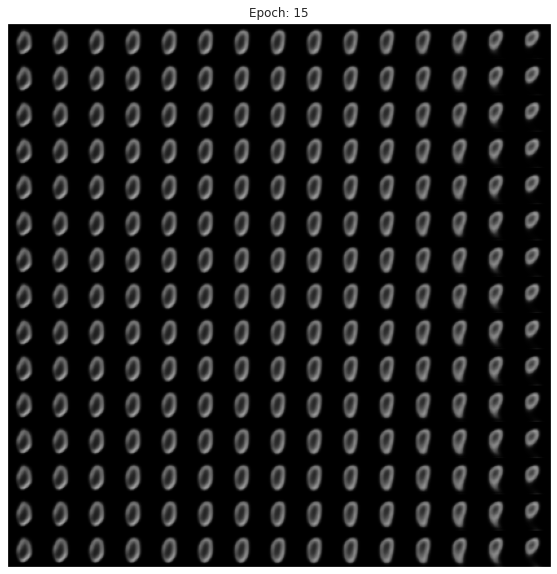

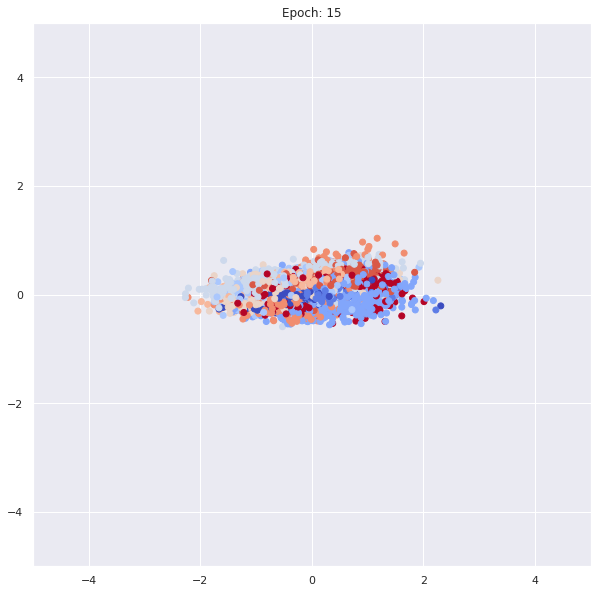

In [44]:
import os
os.makedirs('my_figs', exist_ok=True)

from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='pillow')

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer='pillow')

make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.gif", plt.figure(figsize=(10,10)))
make_2d_scatter_gif([x[0].numpy() for x in latent_distrs], epochs, test_labels, "./my_figs/z_distr2.gif", plt.figure(figsize=(10,10)))